# Synthetic Data (Poisson-Log-Normal)

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import torch
import numpy 
import matplotlib.pyplot as plt
import seaborn
import pandas

### Generate fake data and visualize

In [17]:
from tissue_purifier.model_utils.gene_regression import (
    generate_fake_data, 
    GeneDataset, 
    GeneRegression,
    train_test_val_split,
    plot_few_gene_hist
)

fake_dataset: GeneDataset = generate_fake_data(
    cells=2000,
    genes=50,
    covariates=20,
    cell_types=9,
    alpha_scale=0.001,
    alpha0_loc=-6.0,
    alpha0_scale=0.5,
    noise_scale= 0.001)
    

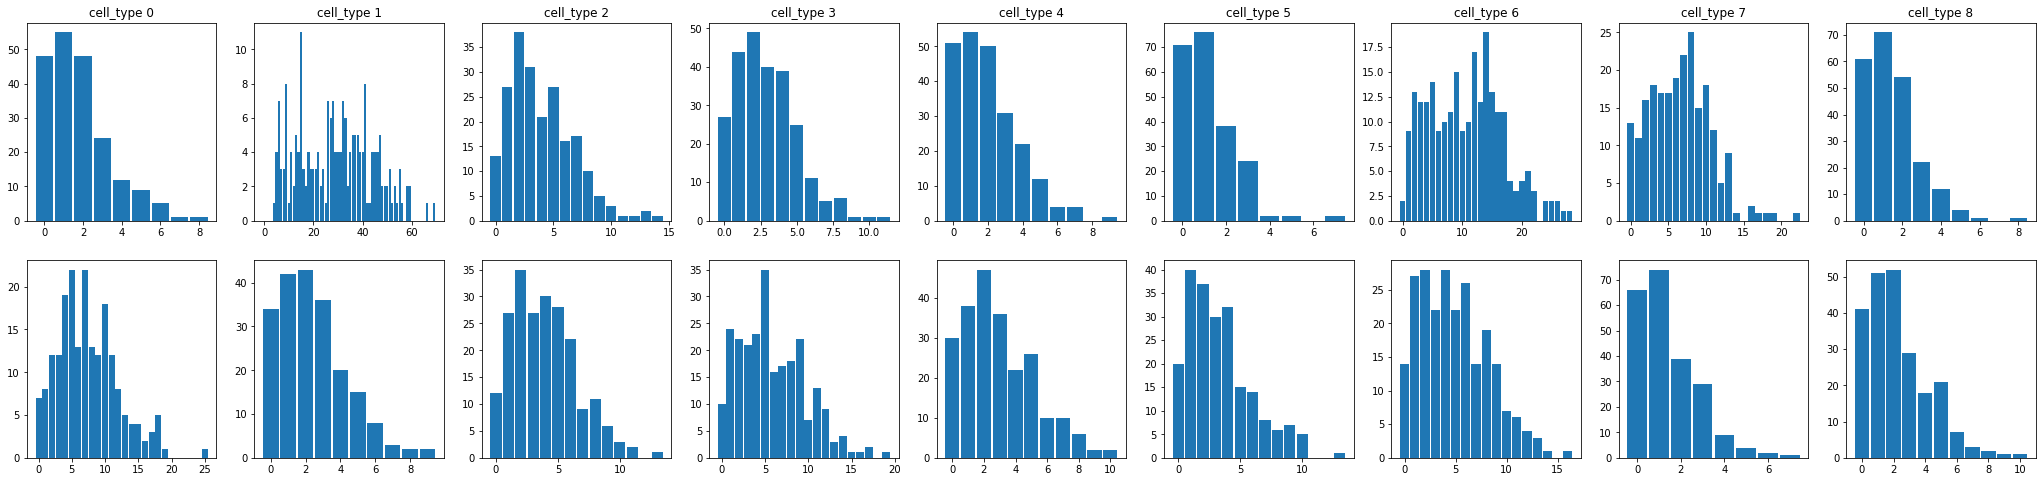

In [19]:
counts_ng = fake_dataset.counts
cell_types_n = fake_dataset.cell_type_ids
fig = plot_few_gene_hist(cell_types_n, counts_ng[:,:2])
fig

# Instantiate the gene_regression model

  Trace Shapes:                
   Param Sites:                
          eps_g              50
         alpha0       9    1 50
  Sample Sites:                
     cells dist               |
          value         2000  |
       log_prob               |
cell_types dist               |
          value            9  |
       log_prob               |
 covariate dist               |
          value           20  |
       log_prob               |
     genes dist               |
          value           50  |
       log_prob               |
     alpha dist    9 20   50  |
          value    9 20   50  |
       log_prob    9 20   50  |
    counts dist 2000  1   50  |
          value 2000  1   50  |
       log_prob 2000  1   50  |


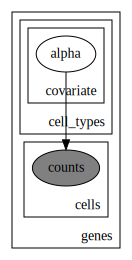

In [20]:
genex = GeneRegression()
genex.render_model(fake_dataset)

### Split Train/Test/Val

In [21]:
sss = train_test_val_split(data=fake_dataset,
                           train_size=0.8,
                           test_size=0.1,
                           val_size=0.1,
                           n_splits=1,
                           stratify=True)

for train_dataset, test_dataset, val_dataset in sss:
    print(train_dataset.counts.shape, test_dataset.counts.shape, val_dataset.counts.shape)

torch.Size([1600, 50]) torch.Size([200, 50]) torch.Size([200, 50])


### Train the model for different value of alpha (i.e. L2 regularization on regression coefficients)

In [26]:
genex.configure_optimizer(optimizer_type='adam', lr=5E-3)

alpha_list = [1E-4, 1E-3, 1E-2, 1E-1, 1.0, 10]
ckpt_list = ["./train_alpha_{0}.pt".format(alpha) for alpha in alpha_list]

for alpha, ckpt_file in zip(alpha_list, ckpt_list):
    genex.train(dataset=train_dataset, 
                alpha_scale=alpha_scale, 
                use_covariates=True, 
                eps_g_range=(1.0E-5, 0.5), 
                n_steps=5, 
                print_frequency=100, 
                from_scratch=True)
    genex.save_ckpt(filename=ckpt_file)

[iter 0]  loss: 6008646.7148
[iter 0]  loss: 6008646.7148
[iter 0]  loss: 6008646.7148
[iter 0]  loss: 6008646.7148
[iter 0]  loss: 6008646.7148
[iter 0]  loss: 6008646.7148


### Evaluation

./train_alpha_0.0001.pt 0.0001 67.22977 207.70877
./train_alpha_0.001.pt 0.001 67.22977 206.72289
./train_alpha_0.01.pt 0.01 67.22977 206.69398
./train_alpha_0.1.pt 0.1 67.22977 207.00488
./train_alpha_1.0.pt 1.0 67.22977 207.49065
./train_alpha_10.pt 10 67.22977 206.71902


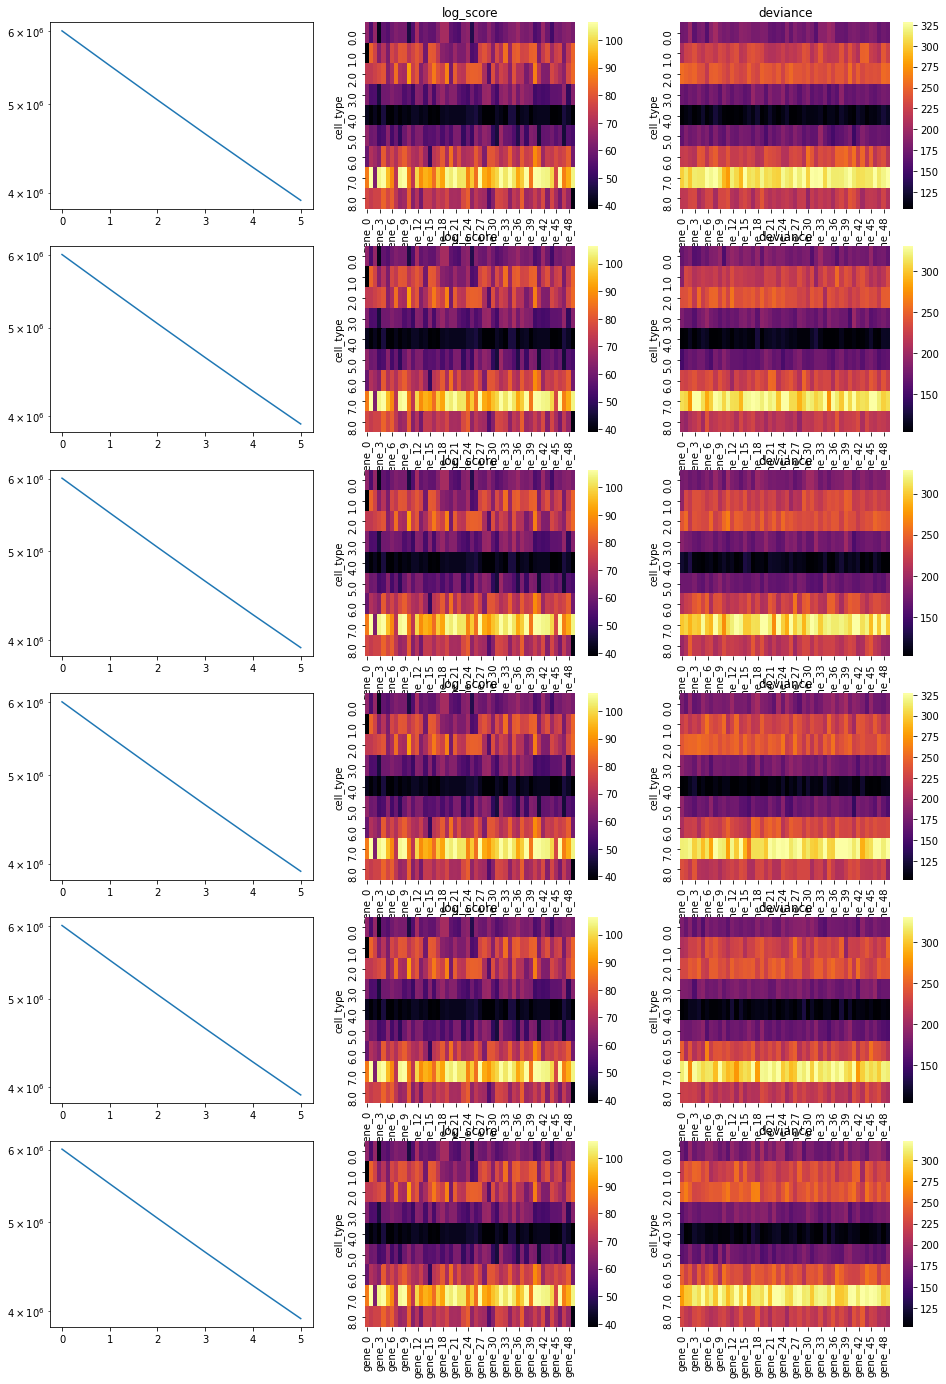

In [42]:
fig, axes = plt.subplots(nrows=len(ckpt_list), ncols=3, figsize=(16,4*len(ckpt_list)))

mean_log_score_list, mean_deviance_list, params_list = [], [], []
for r, (alpha, ckpt_file) in enumerate(zip(alpha_list, ckpt_list)):
    
    genex.load_ckpt(filename=ckpt_file)
    results, df_logscore, df_deviance = genex.predict(dataset=test_dataset)
    params_list.append(genex.get_params())
    
    
    df1 = df_logscore.groupby(by="cell_type").median()
    df2 = df_deviance.groupby(by="cell_type").median()
    
    _ = genex.show_loss(logy=True, logx=False, ax=axes[r,0])
    _ = seaborn.heatmap(data=df1, cmap="inferno", robust=True, ax=axes[r,1])
    _ = axes[r,1].set_title("log_score")
    _ = seaborn.heatmap(data=df2, cmap="inferno", robust=True, ax =axes[r,2])
    _ = axes[r,2].set_title("deviance")
    
    log_score_mean = df1.mean().mean()
    deviance_score_mean = df2.mean().mean()
    mean_log_score_list.append(log_score_mean)
    mean_deviance_list.append(deviance_score_mean)
    
    print(ckpt_file, alpha, log_score_mean, deviance_score_mean)

show that the gene-specific overdispersion does not depend on the L2 regularization strength 

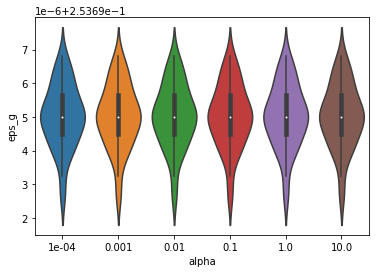

In [103]:
x = None
for n, (alpha, params) in enumerate(zip(alpha_list, params_list)):
    eps_g = params["eps_g"]
    alphas = torch.tensor([alpha]*eps_g.shape[0])
    tmp = torch.stack((alphas, eps_g), dim=-1)
    if x is None:
        x = tmp
    else:
        x = torch.cat((x,tmp), dim=0)
        
df = pandas.DataFrame(x.numpy(), columns = ["alpha", "eps_g"])
_ = seaborn.violinplot(x="alpha", y="eps_g", data=df)
# df.head()

show how the aggregate metri change with the regularization strength

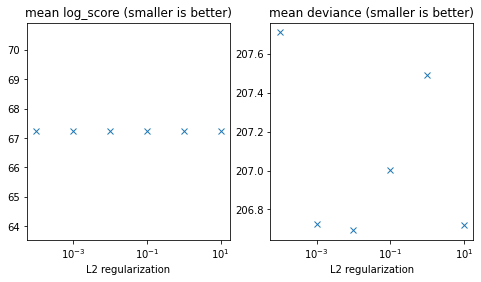

In [104]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
_ = axes[0].plot(alpha_list, mean_log_score_list, 'x')
_ = axes[1].plot(alpha_list, mean_deviance_list, 'x')
_ = axes[0].set_xscale("log")
_ = axes[1].set_xscale("log")
_ = axes[0].set_title("mean log_score (smaller is better)")
_ = axes[1].set_title("mean deviance (smaller is better)")
_ = axes[0].set_xlabel("L2 regularization")
_ = axes[1].set_xlabel("L2 regularization")

### Fix L2 and do a more complete analysis of validation set

train longer if necessary

In [ ]:
# genex.train(dataset=train_dataset, 
#             alpha_scale=alpha_scale, 
#             use_covariates=True, 
#             eps_g_range=(1.0E-5, 0.5), 
#             n_steps=5, 
#             print_frequency=100, 
#             from_scratch=True)
# 
# genex.save_ckpt(filename="./train_final.pt")

or load previously trained model

In [ ]:
ckpt_file = "./train_alpha_0.1.pt"
genex.load_ckpt(filename=ckpt_file)

evaluate on the val_dataset

In [ ]:
results, df_logscore, df_deviance = genex.predict(dataset=val_dataset)
    

# from here
train, cross_validation, test on 
read scoring metrics:
need to add evalute method
    
https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.67.3696&rep=rep1&type=pdf

# FROM HERE. DO THE SUMMARY PLOT

In [ ]:
g = sns.catplot(x="alive", col="cell_type", col_wrap=4,
                data=df_deviance,
                kind="violin")

In [ ]:
nmax = len(log_prob_list)
ncol = 3
nrow = int(numpy.ceil(float(nmax)/ncol))
fig, axes = plt.subplots(ncols=ncol, nrows=nrow, figsize=(4*ncol, 4*nrow))

for n, log_prob in enumerate(log_prob_list):
    r,c = int(n / ncol), n % ncol
    median_kg = compute_median_logprob_per_gene_and_cell_type(cell_types_n, tmp_log_prob)
    mean_log_prob = median_kg.mean()
    _ = seaborn.heatmap(median_kg, cmap="inferno", robust=True, ax=axes[r,c])
    _ = axes[r,c].set_title("mean_log_prob = {0:.3f}".format(mean_log_prob))

In [ ]:
median_kg = compute_median_logprob_per_gene_and_cell_type(cell_types_n, tmp_log_prob)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
_ = fig.suptitle("Distance between true counts distribution and estimates")

_ = seaborn.heatmap(median_kg, cmap="inferno", robust=True, ax=axes[0,0])
_ = axes[0,0].set_title("log_prob model 1")

# FROM HERE

### Just for visualization: Plot the predicted_counts vs the real_counts

In [ ]:
fig_A = plot_few_gene_hist(cell_types_n, true_counts_ng[:,:2], predA_counts_ng[:,:2].int(), ncols=3)
fig_B = plot_few_gene_hist(cell_types_n, true_counts_ng[:,:2], predB_counts_ng[:,:2].int(), ncols=3)
fig_C = plot_few_gene_hist(cell_types_n, true_counts_ng[:,:2], predC_counts_ng[:,:2].int(), ncols=3)

## Quantify the variance 
1. at the level of distributions
2. at the level of single predictions

### at the level of distributions

In [ ]:
true_dist_kgi = compute_per_cell_type_distributions(cell_types_n, true_counts_ng)
predA_dist_kgi = compute_per_cell_type_distributions(cell_types_n, predA_counts_ng)
predB_dist_kgi = compute_per_cell_type_distributions(cell_types_n, predB_counts_ng)
predC_dist_kgi = compute_per_cell_type_distributions(cell_types_n, predC_counts_ng)

In [ ]:
L1_norm_A = L1_between_distributions(true_dist_kgi, predA_dist_kgi, normalize=True)
L1_norm_B = L1_between_distributions(true_dist_kgi, predB_dist_kgi, normalize=True)
L1_norm_C = L1_between_distributions(true_dist_kgi, predC_dist_kgi, normalize=True)

EMD_norm_A = EMD_between_distributions(true_dist_kgi, predA_dist_kgi, normalize=True)
EMD_norm_B = EMD_between_distributions(true_dist_kgi, predB_dist_kgi, normalize=True)
EMD_norm_C = EMD_between_distributions(true_dist_kgi, predC_dist_kgi, normalize=True)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
_ = fig.suptitle("Distance between true counts distribution and estimates")

_ = seaborn.heatmap(L1_norm_A, cmap="inferno", robust=True, ax=axes[0,0])
_ = seaborn.heatmap(L1_norm_B, cmap="inferno", robust=True, ax=axes[0,1])
_ = seaborn.heatmap(L1_norm_C, cmap="inferno", robust=True, ax=axes[0,2])
_ = axes[0,0].set_title("L1 wrt MLE estimates")
_ = axes[0,1].set_title("L1 wrt MAP estimates")
_ = axes[0,2].set_title("L1 wrt MAP estimates, alpha0 no prior")

_ = seaborn.heatmap(EMD_norm_A, cmap="inferno", robust=True, ax=axes[1,0])
_ = seaborn.heatmap(EMD_norm_B, cmap="inferno", robust=True, ax=axes[1,1])
_ = seaborn.heatmap(EMD_norm_C, cmap="inferno", robust=True, ax=axes[1,2])
_ = axes[1,0].set_title("EMD wrt MLE estimates")
_ = axes[1,1].set_title("EMD wrt MAP estimates")
_ = axes[1,2].set_title("EMD wrt MAP estimates, alpha0 no prior")

In [ ]:
print(L1_norm_A.median(), L1_norm_B.median(), L1_norm_C.median())
print(EMD_norm_A.median(), EMD_norm_B.median(), EMD_norm_C.median())

## At the level of single predictions

In [ ]:
from tissue_purifier.misc_utils.validation import (
    create_null_distribution,
    create_heldout_distribution
)

null_dist = create_null_distribution(
    cell_types_n=cell_types_n, 
    counts_ng=counts_ng[:,:10], 
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)   


heldout_dist = create_heldout_distribution(
    cell_types_n=cell_types_n, 
    true_counts_ng=counts_ng[:,:10], 
    pred_counts_ng=counts_ng[:,:10]+1,
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)   

### test the procedure by creating two fake distributions

In [ ]:
null_dist = create_null_distribution(
    cell_types_n=cell_types_n[-1000:], 
    counts_ng=counts_ng[-1000:,:10], 
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)     

heldout_dist = create_null_distribution(
    cell_types_n=cell_types_n[:1000], 
    counts_ng=counts_ng[:1000,:10], 
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)     

In [ ]:
gene_id = 1

x_null = null_dist["cell_type_0"][gene_id,:] / numpy.sum(null_dist["cell_type_0"][gene_id,:], axis=-1, keepdims=True)
x_heldout = heldout_dist["cell_type_0"][gene_id,:] / numpy.sum(heldout_dist["cell_type_0"][gene_id,:], axis=-1, keepdims=True)

barWidth=0.4
plt.bar(null_dist["boundaries"], 
        x_null, 
        width = barWidth,
       label="null")
plt.bar(heldout_dist["boundaries"]+barWidth, 
        x_heldout,
        width = barWidth,
       label="Heldout")
_ = plt.xlim([-1,20])
_ = plt.legend()
_ = plt.title("Distribution of Chi = |counts - counts|")

In [ ]:
gene_id = 6

x_null = null_dist["cell_type_0"][gene_id,:] / numpy.sum(null_dist["cell_type_0"][gene_id,:], axis=-1, keepdims=True)
x_heldout = heldout_dist["cell_type_0"][gene_id,:] / numpy.sum(heldout_dist["cell_type_0"][gene_id,:], axis=-1, keepdims=True)

barWidth=0.4
plt.bar(null_dist["boundaries"], 
        x_null, 
        width = barWidth,
       label="null")
plt.bar(heldout_dist["boundaries"]+barWidth, 
        x_heldout,
        width = barWidth,
       label="Heldout")
_ = plt.xlim([-1,20])
_ = plt.legend()
_ = plt.title("Distribution of Chi = |counts - counts|")

### Two-sample Kolmogorov–Smirnov test
I am asking the question if the two distribution are the same


In [ ]:
from scipy.interpolate import interp1d
from typing import NamedTuple, Union
    
class KS_test(NamedTuple):
    """ 
    Result of the KS test between two empirical distributions.
    """
    x: numpy.ndarray
    f1: numpy.ndarray
    f2: numpy.ndarray
    gap: numpy.ndarray
    ks: Union[float, numpy.ndarray]
    n1: Union[int, numpy.array]
    n2: Union[int, numpy.array]
        

def compute_pvalue_from_ks(ks_test: KS_test) -> numpy.ndarray:
    """
    Compute the p-value using the asymptotic formula 
    see. https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
    """
    n1 = ks_test.n1
    n2 = ks_test.n2
    D = ks_test.ks
    tmp = (2 * D * D * n1 * n2) / (n1 + n2)
    p = 2 * numpy.exp(-tmp)
    return p

    
def compute_KS_test(x1, histo1, x2, histo2) -> KS_test:
    
    # (empirical) cumulative distribution and size of sample
    F1_tmp = histo1.cumsum(axis=-1) # shape (genes, bins)
    n1 = F1_tmp[...,-1:]            # shape (genes, 1)
    F1 = F1_tmp / n1                # shape (genes, bins)
    
    # (empirical) cumulative distribution and size of sample
    F2_tmp = histo2.cumsum(axis=-1) 
    n2 = F2_tmp[..., -1:]
    F2 = F2_tmp / n2
    
    # Interpolate sample 1 on the spacing of sample 2 
    f_interp = interp1d(x1, F1, axis=-1, fill_value=(0.0, 1.0))
    F1_new = f_interp(x2)
    
    # Comute the maximum gap between empirical cumulative distributions
    gap = numpy.abs(F1_new - F2)
    ks = numpy.max(gap, axis=-1, keepdims=True)
    
    return KS_test(x=x2, f1=F1_new, f2=F2, n1=n1, n2=n2, gap=gap, ks=ks)


key_cell_types = []
for key in null_dist.keys():
    if key.startswith("cell_type_"):
        key_cell_types.append(key)
    

#df = pandas.DataFrame()
for k in key_cell_types:        
    
    ks_test_tmp = compute_KS_test(
        x1=null_dist["boundaries"], 
        histo1=null_dist["cell_type_0"], 
        x2=heldout_dist["boundaries"], 
        histo2=heldout_dist["cell_type_0"])
    
    p_values_tmp = compute_pvalue_from_ks(ks_test_tmp)
    
    
    
#    dfdf = pd.DataFrame(columns=["firstname", "lastname"])
#df = df.append({
#     "firstname": "John",
#     "lastname":  "Johny"
#      }, ignore_index=True)
    
    dict_tmp = {'ks' : ks_test_tmp.ks, 'p_value': p_values_tmp, 'cell_type': [k]*len(p_values_tmp)}

In [ ]:
ncol = 4
nmax = len(ks_test.ks)
nrow = int(numpy.ceil(float(nmax) / ncol))

fig, axes = plt.subplots(ncols=ncol, nrows=nrow, figsize=(4*ncol, 4*nrow))
for n in range(nmax):
    r,c = n // ncol, n % ncol
    axes[r,c].plot(ks_test.x, ks_test.f1[n,:])
    axes[r,c].plot(ks_test.x, ks_test.f2[n,:])
    axes[r,c].plot(ks_test.x, ks_test.gap[n,:])
    axes[r,c].set_xlim([0,20])
    axes[r,c].set_title("ks={0:.3} -> pvalue={1:.3}".format(ks_test.ks[n].item(), p_values[n].item()))